# PROJET 7 : EFFECTUEZ UNE PRÉDICTION DE REVENUS :

## PRÉALABLES :

### A - Importation des librairies :

In [1]:
# Importation des librairies :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from collections import Counter
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, shapiro, kstest
import random

### B - Importation des fichiers :

In [2]:
# Importation des données :
dataPrepare = pd.read_csv("data-projet7.csv", decimal=',')
dataPrepare.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


### C - Nettoyage des données :

#### 1 - Rajout d'un centile 41 à la Lituanie :

In [3]:
# Vérification du nombre d'entrées :
dataPrepare.count()

country         11599
year_survey     11599
quantile        11599
nb_quantiles    11599
income          11599
gdpppp          11399
dtype: int64

In [4]:
# Recherche du pays qui ne comporte pas 100 valeurs
dataClean = dataPrepare.groupby(by="country").count()
dataClean[dataClean["year_survey"]!=100]
dataPrepare[dataPrepare["country"]=="LTU"].head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6200,LTU,2008,1,100,566.3453,17571.0
6201,LTU,2008,2,100,1147.0587,17571.0
6202,LTU,2008,3,100,1490.8408,17571.0
6203,LTU,2008,4,100,1746.5715,17571.0
6204,LTU,2008,5,100,1842.9542,17571.0


In [5]:
# Calcul de la moyenne entre le centile 40 et le centile 42 :
(4868.4507+4895.8306)/2

4882.14065

In [6]:
# Ajout d'une ligne pour le centile 41 à la Lituanie :
LTU41 = pd.DataFrame({"country" : "LTU" , "year_survey" : 2008, "quantile" : "41", "nb_quantiles" : 100, "income" : 4882.14065, "gdpppp" : 17571.0}, index=[6239.5])
dataPrepare = dataPrepare.append(LTU41, ignore_index=False)
dataPrepare = dataPrepare.sort_index().reset_index(drop=True)
dataPrepare[dataPrepare["country"]=="LTU"].head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6200,LTU,2008,1,100,566.3453,17571.0
6201,LTU,2008,2,100,1147.0587,17571.0
6202,LTU,2008,3,100,1490.8408,17571.0
6203,LTU,2008,4,100,1746.5715,17571.0
6204,LTU,2008,5,100,1842.9542,17571.0


#### 2 - Suppression des 2 pays sans données "gdpppp"

In [7]:
# Recherche de données manquantes :
dataPrepare["gdpppp"].isnull().sort_values()
dataPrepare[dataPrepare["gdpppp"].isnull()==True]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,NaN
5801,XKX,2008,2,100,508.17133,NaN
5802,XKX,2008,3,100,591.82820,NaN
5803,XKX,2008,4,100,668.00000,NaN
5804,XKX,2008,5,100,730.40220,NaN
...,...,...,...,...,...,...
11295,PSE,2009,96,100,2763.88480,NaN
11296,PSE,2009,97,100,3077.83330,NaN
11297,PSE,2009,98,100,3449.22240,NaN
11298,PSE,2009,99,100,4165.99700,NaN


In [8]:
# Suppression des entrées "XKX" et "PSE" :
countryDrop = ["XKX","PSE"]
dataPrepare.drop(dataPrepare.loc[dataPrepare["country"].isin(countryDrop)].index, inplace=True)

### 3 - Donnée aberrante :

In [9]:
# Classement des pays en fonction du gdpppp.
dataPrepare.sort_values(by="gdpppp").tail()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3271,FJI,2008,72,100,2159.8118,4300332.0
3272,FJI,2008,73,100,2210.0690,4300332.0
3273,FJI,2008,74,100,2255.0156,4300332.0
3275,FJI,2008,76,100,2374.9520,4300332.0
3201,FJI,2008,2,100,384.3323,4300332.0


In [10]:
# remplacement du gdpppp des Fidji (données banque mondiale 2008)
dataPrepare.replace(4300332, 4167, inplace=True)

### D - Préparation des données :

#### 1 - Ajout de colonnes "indice de Gini" et "population" :

In [11]:
# Création d'un dataframe contenant, pour chaque pays présent dans "data", l'indice de Gini et la population :
adds = {"country" : ['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN',
       'CIV', 'CMR', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM',
       'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR', 'GEO',
       'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN', 'IND',
       'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KGZ', 'KHM', 'KOR', 'LAO', 'LBR', 'LKA', 'LTU', 'LUX',
       'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE', 'MNG',
       'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD', 'NOR',
       'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY', 'ROU',
       'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYR',
       'THA', 'TJK', 'TLS', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR', 'URY',
       'USA', 'VEN', 'VNM', 'YEM', 'ZAF', 'COD'],
        "elasticity" : [0.4, 0.66, 0.5, 0.4, 0.5, 0.4, 0.66, 0.66, 0.4,
        0.4, 0.4, 0.66, 0.66, 0.5, 0.66, 0.2, 0.66, 0.5,
        0.66, 0.66, 0.66, 0.66, 0.4, 0.4, 0.4, 0.4, 0.66,
        0.66, 0.66, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.5,
        0.66, 0.66, 0.4, 0.66, 0.66, 0.4, 0.4, 0.5, 0.5,
        0.4, 0.5, 0.5, 0.2, 0.4, 0.4, 0.5, 0.4, 0.5,
        0.66, 0.5, 0.5, 0.4, 0.4, 0.66, 0.5, 0.4, 0.4,
        0.4, 0.66, 0.4, 0.66, 0.66, 0.4, 0.66, 0.4, 0.5,
        0.66, 0.66, 0.66, 0.5, 0.66, 0.66, 0.66, 0.4, 0.2,
        0.5, 0.5, 0.66, 0.66, 0.5, 0.4, 0.4, 0.66,0.4,
        0.4, 0.66, 0.66, 0.4, 0.4, 0.4, 0.2, 0.4, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.66, 0.66, 0.4, 0.66,
        0.4, 0.66, 0.5, 0.5, 0.66, 0.66],
       "gini" : [33.2, 41.4, 34.4, 29.7, 26.6, 27.4, 35.3, 32.4, 40.4,
        33.0, 25.2, 42.2, 53.9, 37.4, 56.2, 33.3, 44.4, 38.5,
        41.5, 46.6, 50.4, 48.0, 31.4, 24.9, 31.9, 28.7, 43.7,
        45.4, 31.5, 34.7, 30.4, 27.4, 36.7, 31.6, 34.8, 36.4,
        43.5, 33.7, 34.4, 48.3, 52.1, 30.4, 30.6, 37.8, 35.7,
        32.8, 40.8, 29.5, 26.8, 39.0, 35.9, 33.7, 32.9, 27.5,
        40.8, 27.7, 30.8, 31.6, 36.4, 35.3, 39.8, 37.3, 34.9,
        35.6, 39.5, 25.7, 42.6, 45.4, 34.2, 33.0, 39.0, 32.7,
        54.0, 32.6, 44.7, 41.0, 34.3, 35.1, 46.2, 28.5, 27.0,
        32.8, 33.5, 49.2, 42.8, 44.4, 29.7, 33.8, 46.2, 36.0,
        37.5, 34.2, 38.6, 36.2, 25.2, 24.2, 28.8, 32.7, 35.8,
        36.4, 34.0, 28.7, 41.9, 34.5, 40.5, 42.8, 26.1, 39.7,
        41.1, 46.9, 35.7, 36.7, 63.0, 42.1],
        "population" : [2970020, 39684290, 2932620, 8295490, 8581300, 10625700, 14252020, 142660380, 7545340,
        3762790, 9560950, 9558440, 190134400, 671613, 4198010, 32889030, 16530190, 1317885000,
        19171240, 18730280, 43737510, 4404630, 1063710, 10298830, 82266370, 5461440, 9338860,
        14296560, 78232130, 45226800, 1340680, 5288720, 836190, 64016220, 61322460, 3860160, 
        22963950, 9518160, 11048470, 13477020, 7808520, 4310220, 10055780, 232374240, 1183209470,
        4398940, 71336480, 27911250, 311570, 7180100, 58438310, 6255280, 128001000, 15484190,
        38705930, 5268400, 13679960, 48683640, 5944950, 3461910, 19842040, 3231290, 479990, 
        2200320, 31163670, 2879430, 19433530, 109170500, 2065430, 13651460, 615880, 2593820, 
        21673320, 3202520, 13341810, 26720370, 14685400, 146339980, 5590060, 16381700, 4709150, 
        26382580, 167808110, 3453680, 28330500, 89405480, 38120560, 10542960, 5998430, 20882980, 
        142805110, 32360620, 6105810, 7381580, 5374620, 2018120, 9148090, 7551120, 19878250, 
        66182070, 7062670, 1036390, 69581850, 23037000, 40681410, 29486340, 46509360, 3331750, 
        301231210, 27247610, 85419590, 21282510, 49119760, 58453680]
       }
adds = pd.DataFrame(adds)
adds.head()

,country,elasticity,gini,population
0,ALB,0.40,33.2,2970020
1,ARG,0.66,41.4,39684290
2,ARM,0.50,34.4,2932620
3,AUT,0.40,29.7,8295490
4,AZE,0.50,26.6,8581300


#### 2 - Jointures et export :

In [12]:
# Jointure de adds (population, indice de gini, et elasticité):
dataPrepare = pd.merge(dataPrepare,adds, on="country")

In [13]:
# Calcul et ajout d'une colonne "revenu moyen" à Data :
average = dataPrepare.groupby("country").mean()
average.rename(columns={"income":"average_income"}, inplace=True)
average_income = average["average_income"]
dataPrepare = pd.merge(dataPrepare, average_income, on="country")

In [14]:
# Export :
# dataPrepare.to_csv("dataCorrected.csv", index=False, encoding="ISO-8859-1")

## MISSION 1 :

In [15]:
# Importation des données :
data = pd.read_csv("dataCorrected.csv")
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,elasticity,gini,population,average_income
0,ALB,2008,1,100,728.89795,7297.0,0.4,33.2,2970020,2994.829902
1,ALB,2008,2,100,916.66235,7297.0,0.4,33.2,2970020,2994.829902
2,ALB,2008,3,100,1010.91600,7297.0,0.4,33.2,2970020,2994.829902
3,ALB,2008,4,100,1086.90780,7297.0,0.4,33.2,2970020,2994.829902
4,ALB,2008,5,100,1132.69970,7297.0,0.4,33.2,2970020,2994.829902


### A - Résumer les données utilisées :

#### 1 - Années des données :

In [16]:
# Vérification des dates :
data.year_survey.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

Il y plusieurs dates différentes entre 2004 et 2011. Étant donné que nos données "income" constituent des indicateurs de proportion et que nos données "gdpppp" sont pondérées en fonction du pouvoir d'achat, ces différences ne devraient pas être trop préjudiciables.

#### 2 - Nombre de pays présents :

In [17]:
# Nombre de pays présents :
data.country.nunique()

114

#### 3 - Population couverte par l'analyse :

In [18]:
# Calcul (sur les données de population mondiale de 2008) :
data.population.unique().sum()/6700000000*100

91.5618146716418

### B - Critique des données :

#### 1 - Type de quantiles :

#### 2 - Qu'est-ce que le $PPP

## MISSION 2 :

### A - Diversité des revenus :

#### 1 - Définition des 6 pays témoins :

In [19]:
# Définition des 6 pays :
SVN = data[data["country"]=="SVN"].reset_index(drop=True)
ZAF = data[data["country"]=="ZAF"].reset_index(drop=True)
FRA = data[data["country"]=="FRA"].reset_index(drop=True)
USA = data[data["country"]=="USA"].reset_index(drop=True)
MLI = data[data["country"]=="MLI"].reset_index(drop=True)
CHN = data[data["country"]=="CHN"].reset_index(drop=True)

#### 2 - Diversité des distribution de revenus :

(0.0, 118.0)

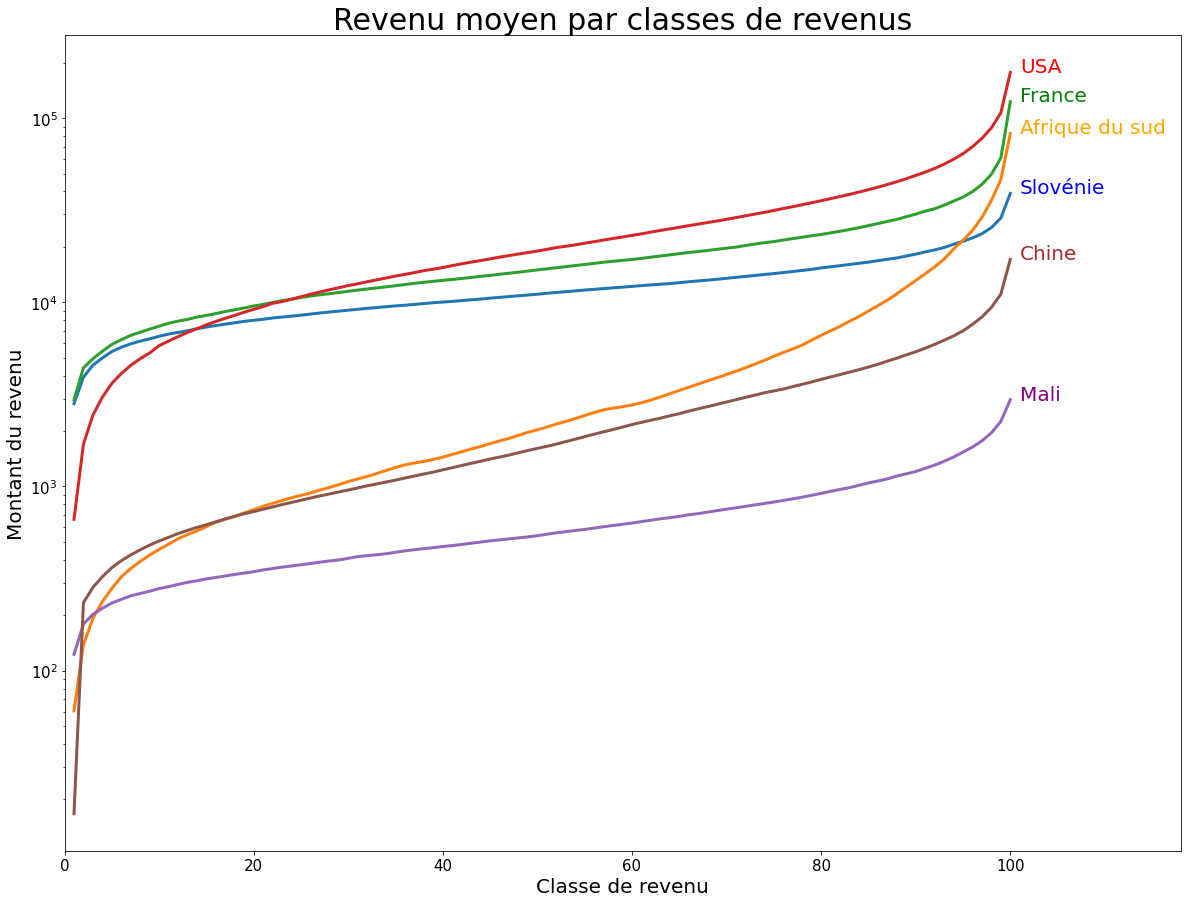

In [20]:
# Visualisation :
plt.figure(figsize=(20,15))
sns.lineplot(data=SVN, x="quantile", y="income", linewidth=3)
sns.lineplot(data=ZAF, x="quantile", y="income", linewidth=3)
sns.lineplot(data=FRA, x="quantile", y="income", linewidth=3)
sns.lineplot(data=USA, x="quantile", y="income", linewidth=3)
sns.lineplot(data=MLI, x="quantile", y="income", linewidth=3)
sns.lineplot(data=CHN, x="quantile", y="income", linewidth=3)
plt.title("Revenu moyen par classes de revenus",size=30)
plt.yscale("log")
plt.tick_params(labelsize=15)
plt.xlabel("Classe de revenu", size=20)
plt.ylabel("Montant du revenu", size=20)
plt.text(101, SVN.income.tail(1), 'Slovénie', horizontalalignment='left', size=20, color='blue')
plt.text(101, ZAF.income.tail(1), 'Afrique du sud', horizontalalignment='left', size=20, color='orange')
plt.text(101, FRA.income.tail(1), 'France', horizontalalignment='left', size=20, color='green')
plt.text(101, USA.income.tail(1), 'USA', horizontalalignment='left', size=20, color='red')
plt.text(101, MLI.income.tail(1), 'Mali', horizontalalignment='left', size=20, color='purple')
plt.text(101, CHN.income.tail(1), 'Chine', horizontalalignment='left', size=20, color='brown')
plt.xlim(0,118)

### B - Courbes de Lorenz :

#### 1 - Définition du tracé d'une courbe de Lorenz :

In [21]:
# Définition :
def lorenz(arr):
    arr_lorenz = arr.cumsum() / arr.sum()
    arr_lorenz[0], arr_lorenz[99]
    fig, ax = plt.subplots(figsize=[5,5])
    ax.plot(np.arange(arr_lorenz.size)/(arr_lorenz.size-1), arr_lorenz, color='orange')
    ax.plot([0,1], [0,1], linestyle='--', color='k')

#### 2 - Tracé des courbes de Lorenz des 6 pays témoins :

None
None
None
None
None
None


Text(0, 0.5, 'Part cumulée des revenus')

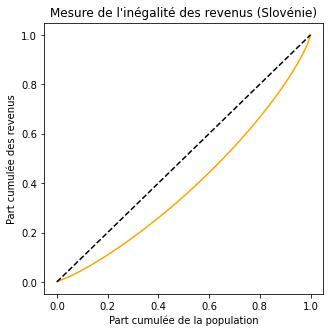

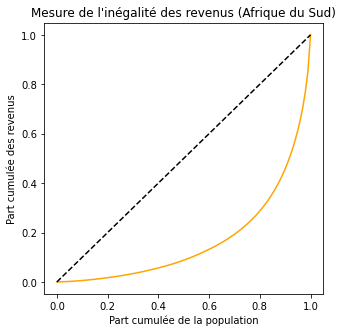

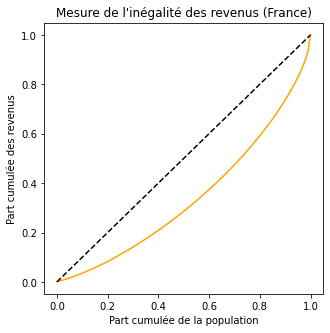

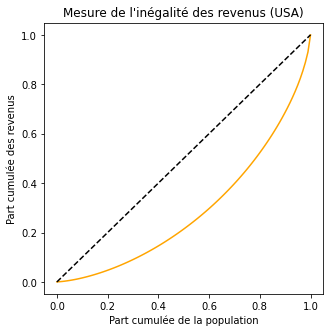

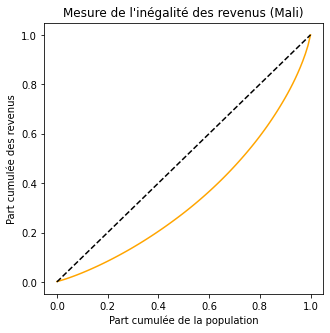

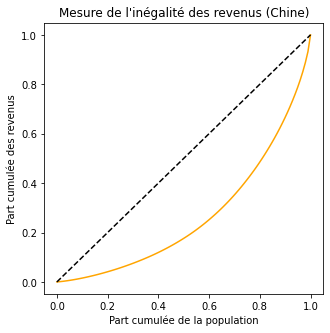

In [22]:
# Slovénie :
arr = SVN["income"]
arr = arr.sort_values()
print(lorenz(arr))
plt.title("Mesure de l'inégalité des revenus (Slovénie)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

# Afrique du Sud :
arr = ZAF["income"]
arr = arr.sort_values()
print(lorenz(arr))
plt.title("Mesure de l'inégalité des revenus (Afrique du Sud)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

# France :
arr = FRA["income"]
arr = arr.sort_values()
print(lorenz(arr))
plt.title("Mesure de l'inégalité des revenus (France)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

# USA :
arr = USA["income"]
arr = arr.sort_values()
print(lorenz(arr))
plt.title("Mesure de l'inégalité des revenus (USA)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

# Mali :
arr = MLI["income"]
arr = arr.sort_values()
print(lorenz(arr))
plt.title("Mesure de l'inégalité des revenus (Mali)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

# Chine :
arr = CHN["income"]
arr = arr.sort_values()
print(lorenz(arr))
plt.title("Mesure de l'inégalité des revenus (Chine)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

#### 3 - Tracé des courbes de Lorenz des 6 pays témoins (ensemble):¶

Text(0, 0.5, 'Part cumulée des revenus')

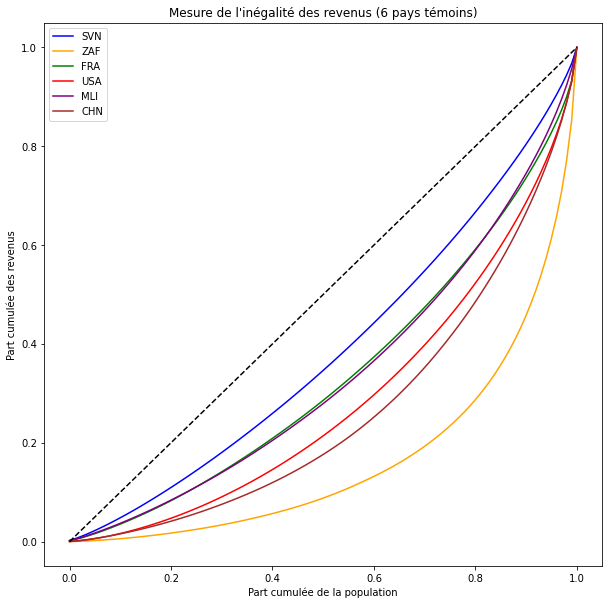

In [23]:
# Définition des calculs par pays

## Slovénie :
arr_SVN = SVN["income"].cumsum() / SVN["income"].sum()
arr_SVN[0], arr_SVN[99]

## Afrique du Sud :
arr_ZAF = ZAF["income"].cumsum() / ZAF["income"].sum()
arr_ZAF[0], arr_ZAF[99]

# France :
arr_FRA = FRA["income"].cumsum() / FRA["income"].sum()
arr_FRA[0], arr_FRA[99]

# USA :
arr_USA = USA["income"].cumsum() / USA["income"].sum()
arr_USA[0], arr_USA[99]

# Mali :
arr_MLI = MLI["income"].cumsum() / MLI["income"].sum()
arr_MLI[0], arr_MLI[99]

# Chine :
arr_CHN = CHN["income"].cumsum() / CHN["income"].sum()
arr_CHN[0], arr_CHN[99]

fig, ax = plt.subplots(figsize=[10,10])

ax.plot(np.arange(arr_SVN.size)/(arr_SVN.size-1), arr_SVN, color='blue', label="SVN")
ax.plot(np.arange(arr_ZAF.size)/(arr_ZAF.size-1), arr_ZAF, color='orange', label="ZAF")
ax.plot(np.arange(arr_FRA.size)/(arr_FRA.size-1), arr_FRA, color='green', label="FRA")
ax.plot(np.arange(arr_USA.size)/(arr_USA.size-1), arr_USA, color='red', label="USA")
ax.plot(np.arange(arr_MLI.size)/(arr_MLI.size-1), arr_MLI, color='purple', label="MLI")
ax.plot(np.arange(arr_CHN.size)/(arr_CHN.size-1), arr_CHN, color='brown', label="CHN")
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.legend()
plt.title("Mesure de l'inégalité des revenus (6 pays témoins)")
plt.xlabel("Part cumulée de la population")
plt.ylabel("Part cumulée des revenus")

### C - Évolution de l'indice de Gini des pays témoins :

#### 1 - Entrée des indicateurs d'évolution de l'indice de Gini entre 2004 et 2017 :

In [24]:
# Création de dataframe regroupant les entrées des valeurs de l'indice de Gini
giniEvo = {"country" : ['SVN', 'ZAF', 'FRA', 'USA', 'MLI', 'CHN'],
    "2004" : [24.8, 0, 30.6, 40.3, 0, 0],
    "2005" : [24.6, 64.8, 29.8, 0, 0, 40.9],
    "2006" : [24.4, 0, 29.7, 0, 38.9, 0],
    "2007" : [24.4, 0, 32.4, 40.8, 0, 0],
    "2008" : [23.7, 63.0, 33.0, 0, 0, 43.0],
    "2009" : [24.8, 0, 32.7, 0, 33.0, 0],
    "2010" : [24.9, 63.4, 33.7, 40.0, 0, 43.7],
    "2011" : [24.9, 0, 33.3, 0, 0, 42.4],
    "2012" : [25.6, 0, 33.1, 0, 0, 42.2],
    "2013" : [26.2, 0, 32.5, 40.7, 0, 39.7],
    "2014" : [25.7, 63.0, 32.3, 0, 0, 39.2],
    "2015" : [25.4, 0, 32.7, 0, 0, 38.6],
    "2016" : [24.8, 0, 31.9, 41.1, 0, 38.5],
    "2017" : [24.2, 0, 31.6, 0, 0, 0]}
            
giniEvo = pd.DataFrame(giniEvo)
giniEvo.replace(0, np.nan, inplace=True)
giniEvo = giniEvo.pivot_table(columns="country")
giniEvo = giniEvo.fillna(method="ffill")
giniEvo.head(10)

country,CHN,FRA,MLI,SVN,USA,ZAF
2004,NaN,30.6,NaN,24.8,40.3,NaN
2005,40.9,29.8,NaN,24.6,40.3,64.8
2006,40.9,29.7,38.9,24.4,40.3,64.8
2007,40.9,32.4,38.9,24.4,40.8,64.8
2008,43.0,33.0,38.9,23.7,40.8,63.0
2009,43.0,32.7,33.0,24.8,40.8,63.0
2010,43.7,33.7,33.0,24.9,40.0,63.4
2011,42.4,33.3,33.0,24.9,40.0,63.4
2012,42.2,33.1,33.0,25.6,40.0,63.4
2013,39.7,32.5,33.0,26.2,40.7,63.4


#### 2 - Visualisation de l'évolution de l'indice de Gini pour les 10 pays témoins :

Text(13, 2017    63.0
Name: ZAF, dtype: float64, 'Afrique du Sud')

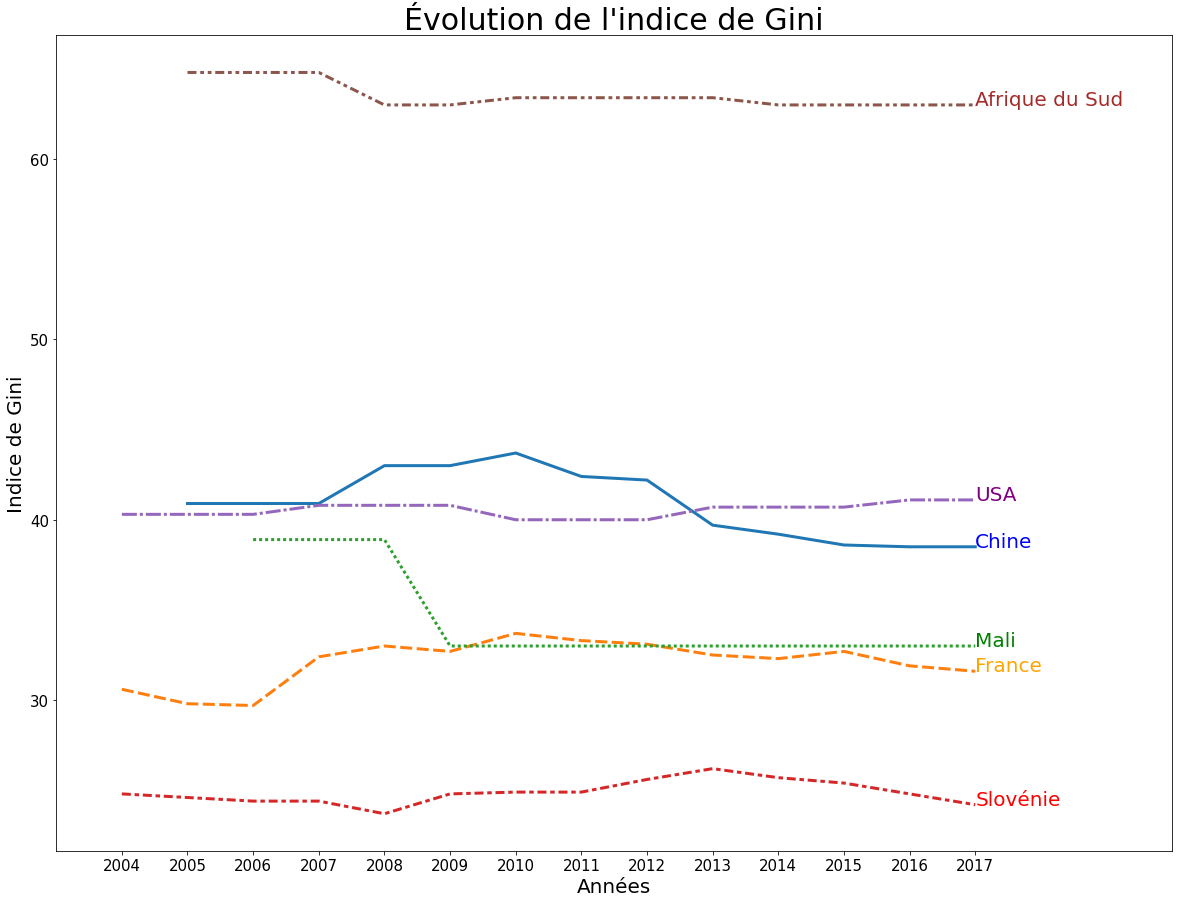

In [25]:
# Visualisation :
plt.figure(figsize=(20,15))
sns.lineplot(data=giniEvo, linewidth=3, legend=None)
plt.title("Évolution de l'indice de Gini",size=30)
plt.tick_params(labelsize=15)
plt.xlabel("Années", size=20)
plt.ylabel("Indice de Gini", size=20)
plt.xlim(-1, 16)
plt.text(13, giniEvo.SVN.tail(1), 'Slovénie', horizontalalignment='left', size=20, color='red')
plt.text(13, giniEvo.FRA.tail(1), 'France', horizontalalignment='left', size=20, color='orange')
plt.text(13, giniEvo.MLI.tail(1), 'Mali', horizontalalignment='left', size=20, color='green')
plt.text(13, giniEvo.USA.tail(1), 'USA', horizontalalignment='left', size=20, color='purple')
plt.text(13, giniEvo.CHN.tail(1), 'Chine', horizontalalignment='left', size=20, color='blue')
plt.text(13, giniEvo.ZAF.tail(1), 'Afrique du Sud', horizontalalignment='left', size=20, color='brown')

#### 3 - Classement par indice de Gini :

In [26]:
# Moyenne de l'indice de Gini (pour l'ensemble des pays présents dans le data):
dataGini = data.groupby(by="country", as_index=False).mean()
dataGini["gini"].mean()

36.699122807017545

In [27]:
# Cinq pays  avec l'indice de Gini le plus bas :
dataGini.sort_values(by="gini").head(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,elasticity,gini,population,average_income
96,SVN,2008.0,50.5,100.0,12106.007475,27197.0,0.4,24.2,2018120.0,12106.007475
24,CZE,2008.0,50.5,100.0,8235.293411,23223.0,0.4,24.9,10298830.0,8235.293411
10,BLR,2008.0,50.5,100.0,3921.163534,11651.0,0.4,25.2,9560950.0,3921.163534
95,SVK,2008.0,50.5,100.0,6096.579894,20515.0,0.4,25.2,5374620.0,6096.579894
66,MDA,2008.0,50.5,100.0,2149.171399,2768.0,0.4,25.7,2879430.0,2149.171399


In [28]:
# Cinq pays  avec l'indice de Gini le plus haut :
dataGini.sort_values(by="gini", ascending=False).head(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,elasticity,gini,population,average_income
113,ZAF,2008.0,50.5,100.0,5617.904880,9602.0,0.66,63.0,49119760.0,5617.904880
14,CAF,2008.0,50.5,100.0,811.299901,685.0,0.66,56.2,4198010.0,811.299901
73,MOZ,2008.0,50.5,100.0,692.480501,773.0,0.66,54.0,21673320.0,692.480501
12,BRA,2008.0,50.5,100.0,4807.484594,9559.0,0.66,53.9,190134400.0,4807.484594
41,HND,2008.0,50.5,100.0,3296.268419,3628.0,0.66,52.1,7808520.0,3296.268419


In [29]:
# Position de la France en terme d'indice de Gini :
dataGini["rank"] = dataGini["gini"].rank(method="min")
dataGini[dataGini["country"]=="FRA"]["rank"]

34    27.0
Name: rank, dtype: float64

## MISSION 3 :

### A - Entrée des variables :

In [30]:
# Variables :
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

###  B - Questions 1, 2 et 3 : génération de "n".

#### 1 - Définition de la fonction de génération :

In [31]:
# Fonction de génération :
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

#### 2 - Génération :

In [32]:
# Génération des revenus Parents/enfant :
y_child, y_parents = generate_incomes(n, pj)

#### 3 - Revenus des parents :

In [33]:
# Affichage du revenu des parents :
y_parents

array([0.85978972, 0.74253817, 2.55531667, ..., 0.21284847, 0.29924951,
       1.5853923 ])

#### 4 - Revenus des enfants :

In [34]:
# Affichage du revenu des enfants :
y_child

array([0.68221558, 2.96919149, 0.30585796, ..., 0.24722129, 1.2326584 ,
       1.36394514])

### C - Question 4 : Calculer les classes de revenu.

#### 1 - Définition des fonctions d'organisation en quantiles :

In [35]:
# Organisation en quantiles :
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

# Adjonction des quantiles aux données :
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

#### 2 - Calculs et affichages des quantiles parents et enfants :

In [36]:
# Calcul et affichages des quantiles parents et enfants :
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,0.682216,0.859790,4,5
1,2.969191,0.742538,8,4
2,0.305858,2.555317,2,9
3,0.263319,1.195614,2,6
4,0.296448,2.818907,2,9


### D - Question 5 : Estimer la distribution conditionnelle.

#### 1 - Définition des fonctions de distribution conditionnelle :

In [37]:
# Distribution :
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

# Distribution conditionnelle :
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)

# Probabilités :
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

#### 2 - Entrée des variables de classes de revenus des enfants et des parents :

In [39]:
# classe du parent et de l'enfant :
classe_du_parent = sample["c_i_parent"]
classe_de_l_enfant = sample["c_i_child"]

# Correspondance avec l'index à 0 :
c_i_parent = classe_du_parent -1
c_i_child = classe_de_l_enfant - 1

In [40]:
# Calcul des probabilités qu'un enfant a de faire partie de la classe c_i_child avec des parents de la classe c_i_parent :
cd = conditional_distributions(sample, nb_quantiles)
p = proba_cond(c_i_parent, c_i_child, cd)
sample["proba"] = p
sample

,y_child,y_parents,c_i_child,c_i_parent,proba
0,0.682216,0.859790,4,5,0.141
1,2.969191,0.742538,8,4,0.088
2,0.305858,2.555317,2,9,0.013
3,0.263319,1.195614,2,6,0.063
4,0.296448,2.818907,2,9,0.013
...,...,...,...,...,...
9995,0.607886,0.843461,4,5,0.141
9996,2.620491,1.508769,8,7,0.134
9997,0.247221,0.212848,2,1,0.190
9998,1.232658,0.299250,6,2,0.081


### E - Question 6 : Vérification à l'aide d'un graphique.

In [93]:
# Visualisation de la distribution conditionnelle :
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()

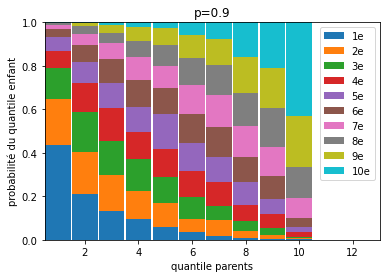

In [94]:
# Visualisation pour pj à 0.9 :
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10

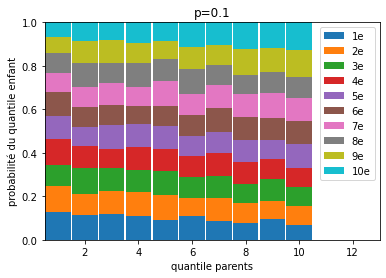

In [95]:
# Visualisation pour pj à 0.1 :
pjTest = 0.1
y_childTest, y_parentsTest = generate_incomes(n, pjTest)
sampleTest = compute_quantiles(y_childTest, y_parentsTest, nb_quantiles)
cdTest = conditional_distributions(sampleTest, nb_quantiles)
plot_conditional_distributions(pjTest, cdTest, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10

### F - Questions 7 à 11 : Application de la méthode précédente sur le data de la World Income Distribution.

#### 1 - Suppression des objets générés précédemment :

In [96]:
# Suppression :
del y_child, y_parents, sample, y_childTest, y_parentsTest, sampleTest

#### 2 - Passage en déciles :

In [97]:
# Colonne décile :
data["decile"] = data["quantile"]/10-0.1
data["decile"] = data["decile"].astype(int)+1

In [98]:
# Regroupement en decile
dataD = data.groupby(["country","decile"], as_index=False).mean()

In [99]:
# Réorganisation du dataframe :
dataD.drop(columns=["quantile","nb_quantiles"], inplace=True)
dataD["year_survey"] = dataD["year_survey"].astype("int32")
dataD["population"] = dataD["population"].astype("int32")
dataD

,country,decile,year_survey,income,gdpppp,elasticity,gini,population,average_income
0,ALB,1,2008,1110.019970,7297.0,0.40,33.2,2970020,2994.829902
1,ALB,2,2008,1513.774410,7297.0,0.40,33.2,2970020,2994.829902
2,ALB,3,2008,1825.459560,7297.0,0.40,33.2,2970020,2994.829902
3,ALB,4,2008,2083.745182,7297.0,0.40,33.2,2970020,2994.829902
4,ALB,5,2008,2370.304967,7297.0,0.40,33.2,2970020,2994.829902
...,...,...,...,...,...,...,...,...,...
1135,ZAF,6,2008,2457.051590,9602.0,0.66,63.0,49119760,5617.904880
1136,ZAF,7,2008,3411.851890,9602.0,0.66,63.0,49119760,5617.904880
1137,ZAF,8,2008,5282.001070,9602.0,0.66,63.0,49119760,5617.904880
1138,ZAF,9,2008,9581.828770,9602.0,0.66,63.0,49119760,5617.904880


#### 3 - Agrandissement de l'échantillon WID (*500)

In [100]:
# Multiplication des lignes et préparation du dataframe "data2"
data2 = pd.DataFrame(np.repeat(dataD.values,500,axis=0))
data2.rename(columns={0:"country", 1:"decile",  3:"income", 4:"gdpppp", 5:"elasticity", 6:"gini", 7:"population", 8:"average_income"}, inplace=True)
data2 = data2[["country","population","income","gdpppp", "average_income", "gini", "elasticity", "decile"]]
data2.head()

,country,population,income,gdpppp,average_income,gini,elasticity,decile
0,ALB,2970020,1110.02,7297,2994.83,33.2,0.4,1
1,ALB,2970020,1110.02,7297,2994.83,33.2,0.4,1
2,ALB,2970020,1110.02,7297,2994.83,33.2,0.4,1
3,ALB,2970020,1110.02,7297,2994.83,33.2,0.4,1
4,ALB,2970020,1110.02,7297,2994.83,33.2,0.4,1


#### 3 - Reconversion des colonnes :

In [101]:
# Conversion :
data2["population"] = data2["population"].astype("float32")
data2["income"] = data2["income"].astype("float32")
data2["gdpppp"] = data2["population"].astype("float32")
data2["average_income"] = data2["average_income"].astype("float32")
data2["gini"] = data2["gini"].astype("float32")
data2["elasticity"] = data2["elasticity"].astype("float32")
data2["decile"] = data2["decile"].astype("int32")

#### 4 - Attribution des classes parents :

In [102]:
# Création d'une liste de compilation :
c_i_parent=0
c_i_child=0
temp=[]

# Pour chaque pays :
for countryName in data2.country.unique():
 
    # Définition des variables :
    pj = data2.loc[data2["country"]==countryName,"elasticity"].iloc[0]
    nb_quantiles = 10
    n = 5000

    # Génération des revenus, attribution des classes et distribution conditionnelle : 
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)

    # Attribution des classes en fonction des probabilités :
    for c_i_child in range(10):
        for c_i_parent in range(10):
            p = proba_cond(c_i_parent, c_i_child, cd)
            temp.extend([c_i_parent+1]*(int(p*500)))

# Récupération de la liste dans une colonne "c_i_parent" :         
data2["c_i_parent"]=temp
data2.head()

,country,population,income,gdpppp,average_income,gini,elasticity,decile,c_i_parent
0,ALB,2970020.0,1110.02002,2970020.0,2994.829834,33.200001,0.4,1,1
1,ALB,2970020.0,1110.02002,2970020.0,2994.829834,33.200001,0.4,1,1
2,ALB,2970020.0,1110.02002,2970020.0,2994.829834,33.200001,0.4,1,1
3,ALB,2970020.0,1110.02002,2970020.0,2994.829834,33.200001,0.4,1,1
4,ALB,2970020.0,1110.02002,2970020.0,2994.829834,33.200001,0.4,1,1


#### 5 - Vérification de la cohérence :

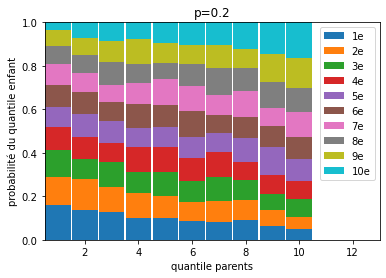

In [103]:
# Vérification de la cohérence (Norvège) :
sampleVerif = data2[data2.country=="NOR"]
sampleVerif = sampleVerif[["decile","c_i_parent"]]
sampleVerif = sampleVerif.rename(columns={"decile":"c_i_child"})

cdVerif = conditional_distributions(sampleVerif,10)
plot_conditional_distributions(0.2, cdVerif, 10)

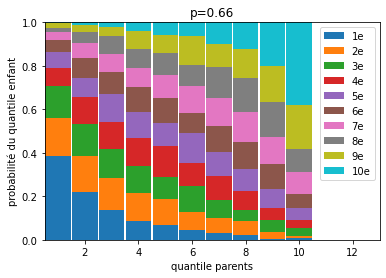

In [104]:
# Vérification de la cohérence (Mexique) :
sampleVerif2 = data2[data2.country=="MEX"]
sampleVerif2 = sampleVerif2[["decile","c_i_parent"]]
sampleVerif2 = sampleVerif2.rename(columns={"decile":"c_i_child"})

cdVerif2 = conditional_distributions(sampleVerif2,10)
plot_conditional_distributions(0.66, cdVerif2, 10)

## MISSION 4 :

### A - ANOVA - revenu/pays (données brutes) :

#### 0 - Analyse descriptive en préalable :

In [105]:
# Sélections des pays observés:
pays_observes = ["SVN", "ZAF", "FRA", "USA", "MLI", "CHN"]
data_obs = data[data["country"].isin(pays_observes)]

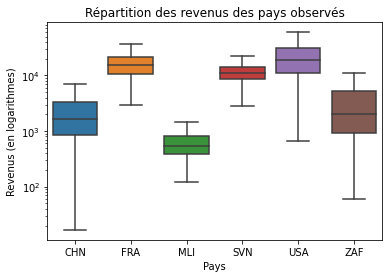

In [106]:
# Visualisation :
ax = sns.boxplot(x=data_obs.country, y=data_obs.income, showfliers = False)
plt.xlabel('Pays')
plt.ylabel('Revenus (en logarithmes)')
plt.title('Répartition des revenus des pays observés')
plt.yscale("log")
plt.show()

#### 1 - ANOVA (données brutes) :

In [107]:
# Calculs :
anovaIncomeCountry = smf.ols("income  ~ country", data=data).fit()
anovaIncomeCountry.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     97.71
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:24:05   Log-Likelihood:            -1.1667e+05
No. Observations:               11400   AIC:                         2.336e+05
Df Residuals:                   11286   BIC:                         2.344e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2994.8299    677.084      4.423      0.000    1667.627    4322.033
country[T.ARG]  2853.0548    957.541      2.980      0.003     976.107    4730.003
country[T.ARM] -1366.4471    957.541     -1.427      0.154   -3243.395     510.501
country[T.AUT]  1.364e+04    957.541     14.248      0.000    1.18e+04    1.55e+04
country[T.AZE]  -637.4009    957.541     -0.666      0.506   -2514.349    1239.547
country[T.BEL]  1.203e+04    957.541     12.563      0.000    1.02e+04    1.39e+04
country[T.BFA] -2076.8772    957.541     -2.169      0.030   -3953.825    -199.929
country[T.BGD] -1996.1375    957.541     -2.085      0.037   -3873.086    -119.189
country[T.BGR]  1990.1487    957.541      2.078      0.038     113.201    3867.097
country[T.BIH]  3339.8574    957.541      3.488      0.000    1462.909    5216.805
country[T.BLR]   926.3336    957.541      0.967      0.333    -950.614    2803.282
country[T.BOL]    21.4339    957.541      0.022      0.982   -1855.514    1898.382
country[T.BRA]  1812.6547    957.541      1.893      0.058     -64.293    3689.603
country[T.BTN] -1478.9008    957.541     -1.544      0.123   -3355.849     398.047
country[T.CAF] -2183.5300    957.541     -2.280      0.023   -4060.478    -306.582
country[T.CAN]  2.074e+04    957.541     21.665      0.000    1.89e+04    2.26e+04
country[T.CHL]  4056.7801    957.541      4.237      0.000    2179.832    5933.728
country[T.CHN]  -472.0712    957.541     -0.493      0.622   -2349.019    1404.877
country[T.CIV] -2594.9947    957.541     -2.710      0.007   -4471.943    -718.047
country[T.CMR] -1200.3359    957.541     -1.254      0.210   -3077.284     676.612
country[T.COD] -2718.8139    957.541     -2.839      0.005   -4595.762    -841.866
country[T.COL]   552.1754    957.541      0.577      0.564   -1324.773    2429.123
country[T.CRI]  2585.5567    957.541      2.700      0.007     708.609    4462.505
country[T.CYP]  1.435e+04    957.541     14.987      0.000    1.25e+04    1.62e+04
country[T.CZE]  5240.4635    957.541      5.473      0.000    3363.515    7117.412
country[T.DEU]  1.507e+04    957.541     15.735      0.000    1.32e+04    1.69e+04
country[T.DNK]  1.405e+04    957.541     14.671      0.000    1.22e+04    1.59e+04
country[T.DOM]   563.5722    957.541      0.589      0.556   -1313.376    2440.520
country[T.ECU]   388.9111    957.541      0.406      0.685   -1488.037    2265.859
country[T.EGY] -1025.2525    957.541     -1.071      0.284   -2902.201     851.696
country[T.ESP]  1.012e+04    957.541     10.571      0.000    8245.215     1.2e+04
country[T.EST]  4707.2327    957.541      4.916      0.000    2830.285    6584.181
country[T.FIN]  1.331e+04    957.541     13.902      0.000    1.14e+04    1.52e+04
country[T.FJI]  -896.0990    957.541     -0.936      0.349   -2773.047     980.849
country[T.FR

#### 2 - Test de Fisher :

In [108]:
# Test de Fisher :
sm.stats.anova_lm(anovaIncomeCountry, typ=2)

,sum_sq,df,F,PR(>F)
country,5.061982e+11,113.0,97.71404,0.0
Residual,5.173986e+11,11286.0,NaN,NaN


#### 3 - Analyse des résidus :

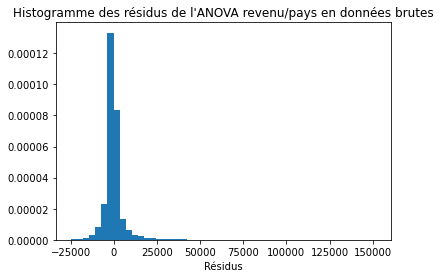

In [109]:
## Valeurs brutes
# Récupération des résidus :
anova_residus = anovaIncomeCountry.resid

# Visualisation :
plt.hist(anova_residus,50,density=True)
plt.xlabel('Résidus')
plt.title("Histogramme des résidus de l'ANOVA revenu/pays en données brutes")
plt.show()

In [112]:
# Test de Kolmogorov-Smirnov :
kstest(anova_residus, "norm")

KstestResult(statistic=0.6562586122912959, pvalue=0.0)

### B - ANOVA - revenu/pays (Logarithmes) :

#### 1 - ANOVA (log)

In [116]:
# Calculs :
lnIncome = np.log(data.income)
anovaIncomeCountryLn = smf.ols("lnIncome  ~ country", data=data).fit()
anovaIncomeCountryLn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lnIncome   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     270.2
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:29:41   Log-Likelihood:                -12441.
No. Observations:               11400   AIC:                         2.511e+04
Df Residuals:                   11286   BIC:                         2.595e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.8517      0.072    108.405      0.000       7.710       7.994
country[T.ARG]     0.4503      0.102      4.397      0.000       0.250       0.651
country[T.ARM]    -0.5698      0.102     -5.562      0.000      -0.771      -0.369
country[T.AUT]     1.7383      0.102     16.970      0.000       1.537       1.939
country[T.AZE]    -0.2478      0.102     -2.419      0.016      -0.449      -0.047
country[T.BEL]     1.6256      0.102     15.871      0.000       1.425       1.826
country[T.BFA]    -1.2919      0.102    -12.612      0.000      -1.493      -1.091
country[T.BGD]    -1.1071      0.102    -10.808      0.000      -1.308      -0.906
country[T.BGR]     0.4234      0.102      4.134      0.000       0.223       0.624
country[T.BIH]     0.6881      0.102      6.717      0.000       0.487       0.889
country[T.BLR]     0.3059      0.102      2.986      0.003       0.105       0.507
country[T.BOL]    -0.4927      0.102     -4.810      0.000      -0.693      -0.292
country[T.BRA]     0.0789      0.102      0.770      0.441      -0.122       0.280
country[T.BTN]    -0.7669      0.102     -7.487      0.000      -0.968      -0.566
country[T.CAF]    -1.7210      0.102    -16.801      0.000      -1.922      -1.520
country[T.CAN]     1.9628      0.102     19.162      0.000       1.762       2.164
country[T.CHL]     0.5107      0.102      4.986      0.000       0.310       0.711
country[T.CHN]    -0.4538      0.102     -4.430      0.000      -0.655      -0.253
country[T.CIV]    -2.1571      0.102    -21.060      0.000      -2.358      -1.956
country[T.CMR]    -0.6061      0.102     -5.917      0.000      -0.807      -0.405
country[T.COD]    -2.5637      0.102    -25.029      0.000      -2.764      -2.363
country[T.COL]    -0.2953      0.102     -2.883      0.004      -0.496      -0.095
country[T.CRI]     0.3491      0.102      3.408      0.001       0.148       0.550
country[T.CYP]     1.7782      0.102     17.360      0.000       1.577       1.979
country[T.CZE]     1.0542      0.102     10.292      0.000       0.853       1.255
country[T.DEU]     1.7885      0.102     17.460      0.000       1.588       1.989
country[T.DNK]     1.7707      0.102     17.286      0.000       1.570       1.971
country[T.DOM]    -0.1183      0.102     -1.155      0.248      -0.319       0.082
country[T.ECU]    -0.2007      0.102     -1.960      0.050      -0.402    3.47e-05
country[T.EGY]    -0.4473      0.102     -4.367      0.000      -0.648      -0.247
country[T.ESP]     1.4575      0.102     14.229      0.000       1.257       1.658
country[T.EST]     0.9424      0.102      9.200      0.000       0.742       1.143
country[T.FIN]     1.7185      0.102     16.777      0.000       1.518       1.919
country[T.FJI]    -0.5096      0.102     -4.975      0.000      -0.710      -0.309
country[T.FR

#### 2 - Test de Fisher (log)

In [58]:
# Test de Fisher :
sm.stats.anova_lm(anovaIncomeCountryLn, typ=2)

,sum_sq,df,F,PR(>F)
country,16016.369220,113.0,270.182227,0.0
Residual,5920.643314,11286.0,NaN,NaN


#### 3 - Analyse des résidus (log)

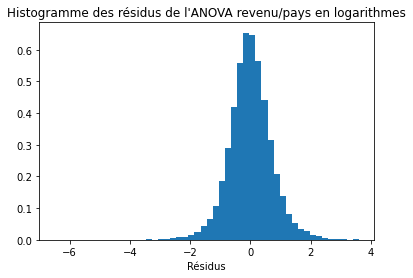

In [117]:
## (LOG)
# Récupération des résidus :
anova_residusLn = anovaIncomeCountryLn.resid

# Visualisation :
plt.hist(anova_residusLn, 50, density=True)
plt.xlabel('Résidus')
plt.title("Histogramme des résidus de l'ANOVA revenu/pays en logarithmes")
plt.show()

In [118]:
# Test de Kolmogorov-Smirnov :
kstest(anova_residusLn, "norm")

KstestResult(statistic=0.1077231669282189, pvalue=1.172823240990608e-115)

### C - Régression linéaire -  revenu / revenu moyen & indice de Gini :

#### 1 - Régression linéaire revenu / revenu moyen & indice de Gini (données brutes) :

In [120]:
# Régression linéaire :
regAvincomeGini = smf.ols("income  ~ gini+average_income", data=data).fit()
regAvincomeGini.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     5575.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:30:12   Log-Likelihood:            -1.1667e+05
No. Observations:               11400   AIC:                         2.333e+05
Df Residuals:                   11397   BIC:                         2.334e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.842e-11    363.133   5.07e-14      1.000    -711.803     711.803
gini           -4.015e-13      9.092  -4.42e-14      1.000     -17.821      17.821
average_income     1.0000      0.010    100.292      0.000       0.980       1.020
==============================================================================
Omnibus:                    14329.924   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3998771.888
Skew:                           6.686   Prob(JB):                         0.00
Kurtosis:                      93.773   Cond. No.                     5.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2 - Représentation des résidus :

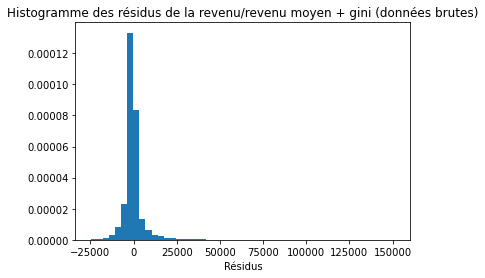

In [121]:
# Récupération des résidus :
regAvincomeGini_residus = regAvincomeGini.resid

# Visualisation :
plt.hist(regAvincomeGini_residus,50,density=True)
plt.xlabel('Résidus')
plt.title("Histogramme des résidus de la revenu/revenu moyen + gini (données brutes)")
plt.show()

In [126]:
# Test de Kolmogorov-Smirnov :
kstest(regAvincomeGini_residus, "norm")

KstestResult(statistic=0.6562586122912971, pvalue=0.0)

#### 3 - Analyse des leviers :

In [62]:
# Niveau de test, nbre d'individus et de variables :
alpha = 0.05
n = data.shape[0]
p = 3

In [63]:
# Dataframe d'analyse :
analysesRegAvincomeGini = pd.DataFrame({'obs':np.arange(1, n+1)})
analysesRegAvincomeGini["obs"] = analysesRegAvincomeGini['obs'].astype('float')

In [64]:
# Calculs :
analysesRegAvincomeGini['levier'] = regAvincomeGini.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

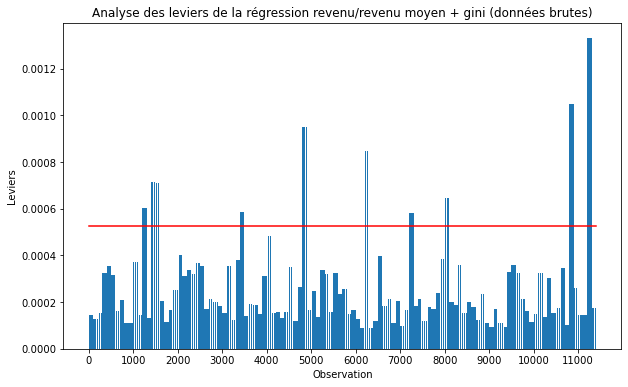

In [65]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGini['obs'], analysesRegAvincomeGini['levier'])
plt.xticks(np.arange(0, n, step=1000))
plt.title("Analyse des leviers de la régression revenu/revenu moyen + gini (données brutes)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()

In [66]:
# Valeurs supérieures au seuil :
analysesRegAvincomeGini.loc[analysesRegAvincomeGini['levier'] > seuil_levier, :]

,obs,levier
1200,1201.0,0.000602
1201,1202.0,0.000602
1202,1203.0,0.000602
1203,1204.0,0.000602
1204,1205.0,0.000602
...,...,...
11295,11296.0,0.001330
11296,11297.0,0.001330
11297,11298.0,0.001330
11298,11299.0,0.001330


#### 4 - Analyse des résidus studentisés :

In [67]:
# Calculs :
analysesRegAvincomeGini['rstudent'] = regAvincomeGini.get_influence().resid_studentized_internal
seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1)

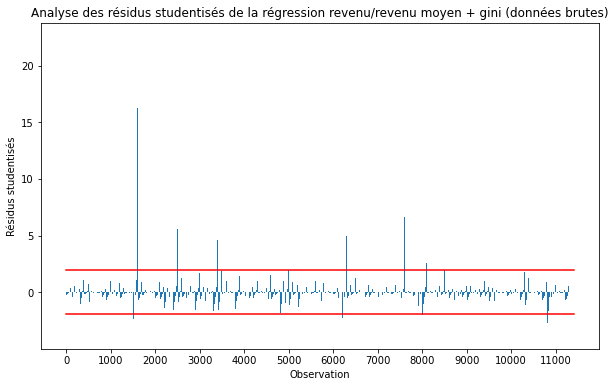

In [68]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGini['obs'], analysesRegAvincomeGini['rstudent'])
plt.xticks(np.arange(0, n, step=1000))
plt.title("Analyse des résidus studentisés de la régression revenu/revenu moyen + gini (données brutes)")
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### 5 - Distance de Cook :

In [138]:
# Seuil de la distance de Cook :
analysesRegAvincomeGini['dcooks'] = regAvincomeGini.get_influence().cooks_distance[0]
seuil_dcook = 4/(n-p)

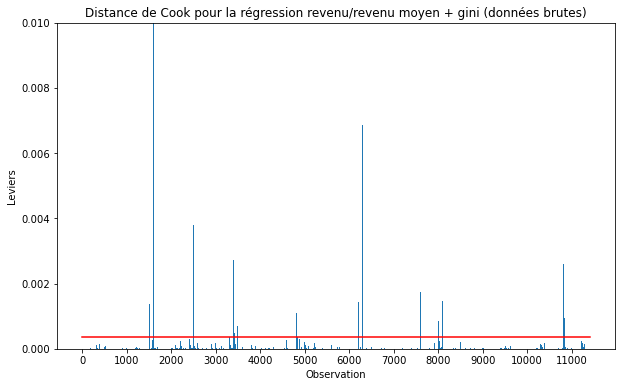

In [147]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGini['obs'], analysesRegAvincomeGini['dcooks'])
plt.xticks(np.arange(0, n, step=1000))
plt.title("Distance de Cook pour la régression revenu/revenu moyen + gini (données brutes)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.ylim(0,0.01)
plt.show()

#### 6 - Colinéarité des variables :

In [72]:
# Calculs :
variablesRegAvincomeGini = regAvincomeGini.model.exog
[variance_inflation_factor(variablesRegAvincomeGini, i) for i in np.arange(1,variablesRegAvincomeGini.shape[1])]

[1.108551485073845, 1.108551485073845]

#### 7 - Homoscédasticité

In [73]:
# Calculs :
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regAvincomeGini.resid, variablesRegAvincomeGini)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.090945943414918e-71


### D - Régression linéaire / revenu moyen & indice de Gini (log) :

#### 1 - Régression linéaire revenu / revenu moyen & indice de Gini (logarithmes) :

In [123]:
# Régression linéaire :
lnAverage_income = np.log(data.average_income)
regAvincomeGiniLn = smf.ols("lnIncome  ~ gini+lnAverage_income", data=data).fit()
regAvincomeGiniLn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lnIncome   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 1.517e+04
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:30:30   Log-Likelihood:                -12507.
No. Observations:               11400   AIC:                         2.502e+04
Df Residuals:                   11397   BIC:                         2.504e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4153      0.068      6.110      0.000       0.282       0.549
gini                -0.0172      0.001    -17.940      0.000      -0.019      -0.015
lnAverage_income     0.9937      0.006    163.067      0.000       0.982       1.006
==============================================================================
Omnibus:                      789.745   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3596.167
Skew:                          -0.168   Prob(JB):                         0.00
Kurtosis:                       5.731   Cond. No.                         384.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2 - Représentation des résidus :

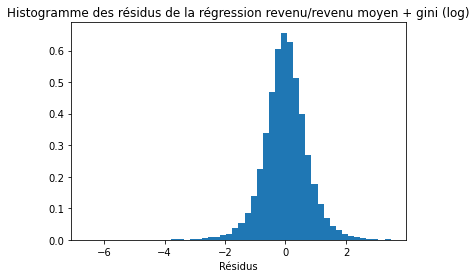

In [124]:
# Récupération des résidus :
regAvincomeGiniLn_residus = regAvincomeGiniLn.resid

# Visualisation :
plt.hist(regAvincomeGiniLn_residus,50,density=True)
plt.xlabel('Résidus')
plt.title("Histogramme des résidus de la régression revenu/revenu moyen + gini (log)")
plt.show()

In [125]:
# Test de Kolmogorov-Smirnov :
kstest(regAvincomeGiniLn_residus, "norm")

KstestResult(statistic=0.10606702186034939, pvalue=3.9225198773983294e-112)

#### 3 - Analyse des leviers :

In [76]:
# Dataframe d'analyse :
analysesRegAvincomeGiniLn = pd.DataFrame({'obs':np.arange(1, n+1)})
analysesRegAvincomeGiniLn["obs"] = analysesRegAvincomeGiniLn['obs'].astype('float')

In [77]:
# Calculs :
analysesRegAvincomeGiniLn['levier'] = regAvincomeGiniLn.get_influence().hat_matrix_diag

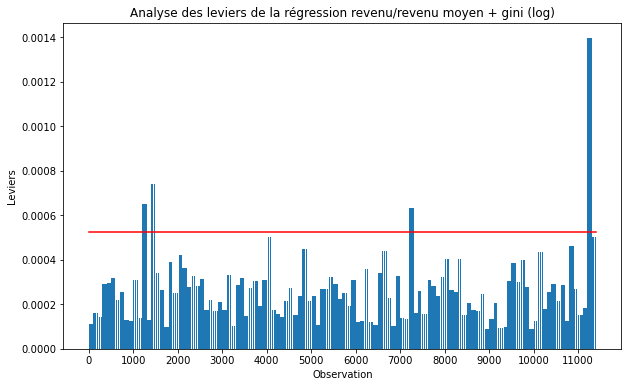

In [78]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniLn['obs'], analysesRegAvincomeGiniLn['levier'])
plt.xticks(np.arange(0, n, step=1000))
plt.title("Analyse des leviers de la régression revenu/revenu moyen + gini (log)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()

In [79]:
# Valeurs supérieures au seuil :
analysesRegAvincomeGiniLn.loc[analysesRegAvincomeGiniLn['levier'] > seuil_levier, :]

,obs,levier
1200,1201.0,0.000651
1201,1202.0,0.000651
1202,1203.0,0.000651
1203,1204.0,0.000651
1204,1205.0,0.000651
...,...,...
11295,11296.0,0.001397
11296,11297.0,0.001397
11297,11298.0,0.001397
11298,11299.0,0.001397


#### 4 - Analyse des résidus studentisés :

In [80]:
# Calculs :
analysesRegAvincomeGiniLn['rstudentLog'] = regAvincomeGiniLn.get_influence().resid_studentized_internal
seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1)

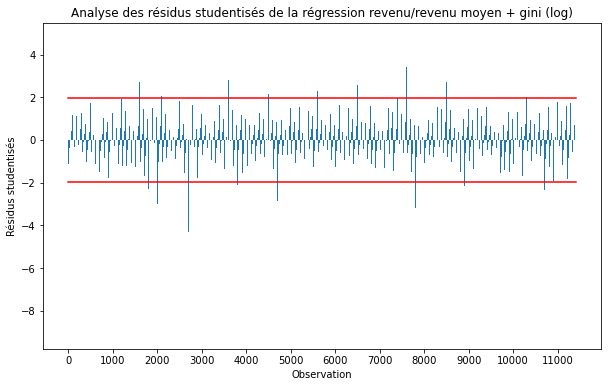

In [81]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniLn['obs'], analysesRegAvincomeGiniLn['rstudentLog'])
plt.xticks(np.arange(0, n, step=1000))
plt.title("Analyse des résidus studentisés de la régression revenu/revenu moyen + gini (log)")
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### 5 - Distance de Cook :

In [149]:
# Seuil de la distance de Cook :
analysesRegAvincomeGiniLn['dcooks'] = regAvincomeGiniLn.get_influence().cooks_distance[0]
seuil_dcook = 4/(n-p)

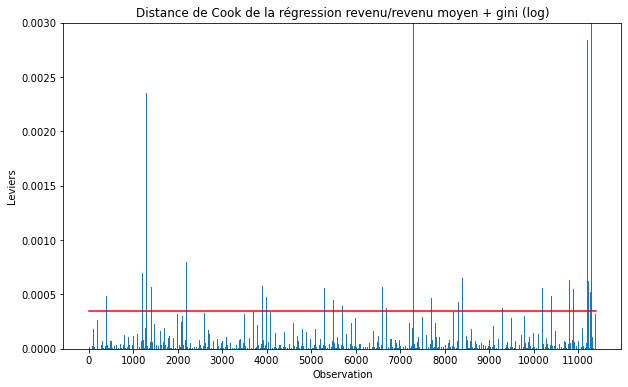

In [152]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniLn['obs'], analysesRegAvincomeGiniLn['dcooks'])
plt.xticks(np.arange(0, n, step=1000))
plt.title("Distance de Cook de la régression revenu/revenu moyen + gini (log)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.ylim(0, 0.003)
plt.show()

#### 6 - Colinéarité des variables :

In [85]:
# Calculs
variablesRegAvincomeGiniLn = regAvincomeGiniLn.model.exog
[variance_inflation_factor(variablesRegAvincomeGiniLn, i) for i in np.arange(1,variablesRegAvincomeGiniLn.shape[1])]

[1.0686762336920521, 1.0686762336920521]

#### 7 - homoscédasticité

In [86]:
# Calculs :
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regAvincomeGiniLn.resid, variablesRegAvincomeGiniLn)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.5743071220842076e-107


## AVERTISSEMENT :

### E - Régression linéaire -  revenu / revenu moyen & indice de Gini & quantile parents :

#### 1 - Régression linéaire revenu / revenu moyen & indice de Gini & quantile parents (données brutes) :

In [127]:
# Régression linéaire :
regAvincomeGiniQuant = smf.ols("income ~ gini+average_income+c_i_parent", data=data2).fit()
regAvincomeGiniQuant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                 2.835e+05
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:31:44   Log-Likelihood:            -5.7258e+06
No. Observations:              570000   AIC:                         1.145e+07
Df Residuals:                  569996   BIC:                         1.145e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2653.0727     44.795    -59.227      0.000   -2740.869   -2565.276
gini               0.0646      1.064      0.061      0.952      -2.021       2.150
average_income     1.0010      0.001    857.724      0.000       0.999       1.003
c_i_parent       481.9550      2.572    187.418      0.000     476.915     486.995
==============================================================================
Omnibus:                   372990.298   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8411188.106
Skew:                           2.812   Prob(JB):                         0.00
Kurtosis:                      20.959   Cond. No.                     5.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2 - Représentation des résidus :

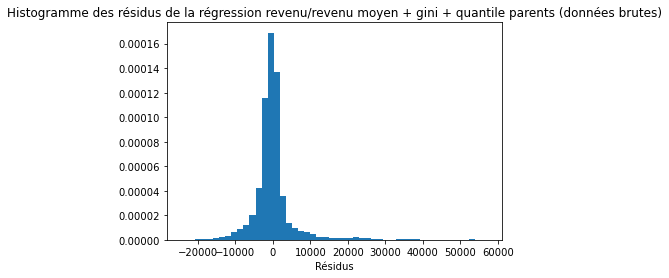

In [128]:
# Récupération des résidus :
regAvincomeGiniQuant_residus = regAvincomeGiniQuant.resid

# Visualisation :
plt.hist(regAvincomeGiniQuant_residus,50,density=True)
plt.xlabel('Résidus')
plt.title("Histogramme des résidus de la régression revenu/revenu moyen + gini + quantile parents (données brutes)")
plt.show()

In [129]:
# Test de Kolmogorov-Smirnov :
kstest(regAvincomeGiniQuant_residus, "norm")

KstestResult(statistic=0.5774596086674669, pvalue=0.0)

#### 3 - Analyse des leviers :

In [159]:
# Niveau de test, nbre d'individus et de variables :
alpha = 0.05
n = data2.shape[0]
p = 4
seuil_levier = 2*p/n

In [90]:
# Dataframe d'analyse
analysesRegAvincomeGiniQuant = pd.DataFrame({'obs':np.arange(1, n+1)})
analysesRegAvincomeGiniQuant["obs"] = analysesRegAvincomeGiniQuant['obs'].astype('float')

In [91]:
# Calculs :
analysesRegAvincomeGiniQuant['levier'] = regAvincomeGiniQuant.get_influence().hat_matrix_diag

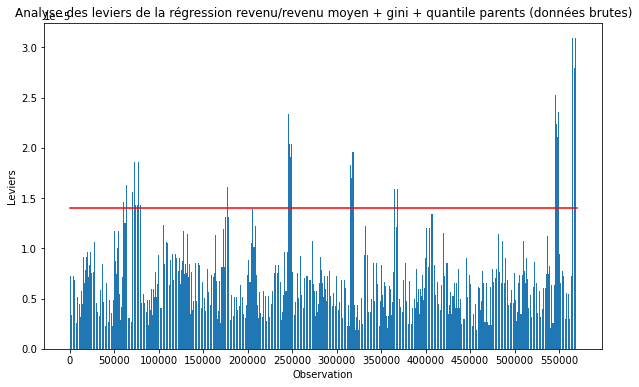

In [92]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniQuant['obs'], analysesRegAvincomeGiniQuant['levier'])
plt.xticks(np.arange(0, n, step=50000))
plt.title("Analyse des leviers de la régression revenu/revenu moyen + gini + quantile parents (données brutes)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()

#### 4 - Analyse des résidus studentisés :

In [93]:
# Calculs :
analysesRegAvincomeGiniQuant['rstudent'] = regAvincomeGiniQuant.get_influence().resid_studentized_internal
seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1)

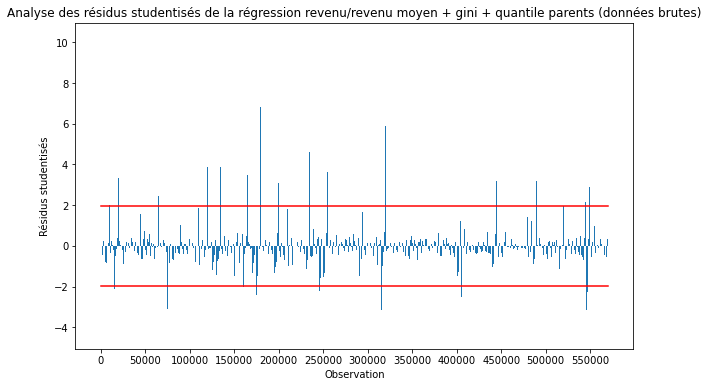

In [94]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniQuant['obs'], analysesRegAvincomeGiniQuant['rstudent'])
plt.xticks(np.arange(0, n, step=50000))
plt.title("Analyse des résidus studentisés de la régression revenu/revenu moyen + gini + quantile parents (données brutes)")
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### 5 - Distance de Cook : 

In [160]:
# Seuil de la distance de Cook :
analysesRegAvincomeGiniQuant['dcooks'] = regAvincomeGiniQuant.get_influence().cooks_distance[0]
seuil_dcook = 4/(n-p)

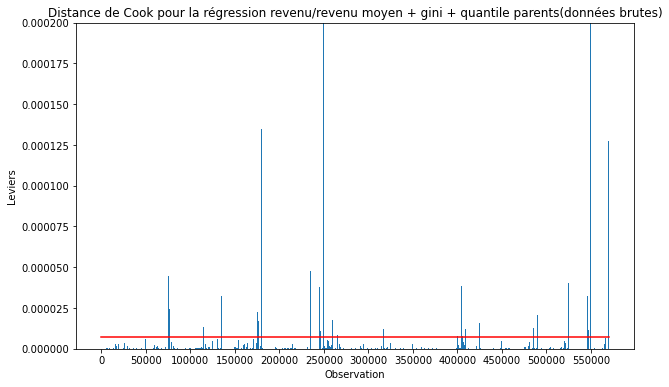

In [162]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniQuant['obs'], analysesRegAvincomeGiniQuant['dcooks'])
plt.xticks(np.arange(0, n, step=50000))
plt.title("Distance de Cook pour la régression revenu/revenu moyen + gini + quantile parents(données brutes)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.ylim(0,0.0002)
plt.show()

#### 6 - Colinéarité des variables :

In [97]:
# Calculs :
variablesRegAvincomeGiniQuant = regAvincomeGiniQuant.model.exog
[variance_inflation_factor(variablesRegAvincomeGiniQuant, i) for i in np.arange(1,variablesRegAvincomeGiniQuant.shape[1])]

[1.108551490979998, 1.1085514909800243, 1.0000000000000009]

#### 7 - homoscédasticité

In [98]:
# Calculs :
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regAvincomeGiniQuant.resid, variablesRegAvincomeGiniQuant)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.0


### F - Régression linéaire revenu / revenu moyen & indice de Gini & quantile parents (logarithmes) :

#### 1 - Régression linéaire revenu / revenu moyen & indice de Gini & quantile parents (logarithmes) :

In [131]:
# Transformation des variables en logarithmes :
data2["income_log"] = np.log(data2["income"])
data2["average_income_log"] = np.log(data2["average_income"])

In [132]:
# Régression linéaire :
regAvincomeGiniQuantLog = smf.ols("income_log ~ gini+average_income_log+c_i_parent", data=data2).fit()
regAvincomeGiniQuantLog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             income_log   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 6.898e+05
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        10:55:17   Log-Likelihood:            -5.5414e+05
No. Observations:              570000   AIC:                         1.108e+06
Df Residuals:                  569996   BIC:                         1.108e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1831      0.009    -21.200      0.000      -0.200      -0.166
gini                  -0.0163      0.000   -135.705      0.000      -0.017      -0.016
average_income_log     0.9957      0.001   1309.418      0.000       0.994       0.997
c_i_parent             0.1026      0.000    347.912      0.000       0.102       0.103
==============================================================================
Omnibus:                     4633.956   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6717.239
Skew:                           0.091   Prob(JB):                         0.00
Kurtosis:                       3.500   Cond. No.                         395.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2 - Représentation des résidus :

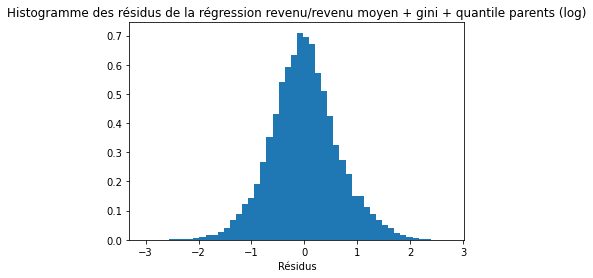

In [133]:
# Récupération des résidus :
regAvincomeGiniQuantLog_residus = regAvincomeGiniQuantLog.resid

# Visualisation :
plt.hist(regAvincomeGiniQuantLog_residus,50,density=True)
plt.xlabel('Résidus')
plt.title("Histogramme des résidus de la régression revenu/revenu moyen + gini + quantile parents (log)")
plt.show()

In [134]:
# Test de Kolmogorov-Smirnov :
kstest(regAvincomeGiniQuantLog_residus, "norm")

KstestResult(statistic=0.12092835823398794, pvalue=0.0)

#### 3 - Analyse des leviers :

In [102]:
# Dataframe d'analyse
analysesRegAvincomeGiniQuantLog = pd.DataFrame({'obs':np.arange(1, n+1)})
analysesRegAvincomeGiniQuantLog["obs"] = analysesRegAvincomeGiniQuantLog['obs'].astype('float')

In [103]:
# Calculs :
analysesRegAvincomeGiniQuantLog['levier'] = regAvincomeGiniQuantLog.get_influence().hat_matrix_diag

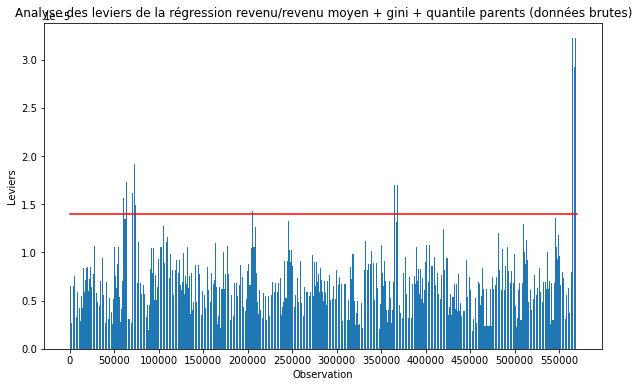

In [104]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniQuantLog['obs'], analysesRegAvincomeGiniQuantLog['levier'])
plt.xticks(np.arange(0, n, step=50000))
plt.title("Analyse des leviers de la régression revenu/revenu moyen + gini + quantile parents (données brutes)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()

#### 4 - Analyse des résidus studentisés :

In [105]:
# Calculs :
analysesRegAvincomeGiniQuantLog['rstudent'] = regAvincomeGiniQuantLog.get_influence().resid_studentized_internal
seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1)

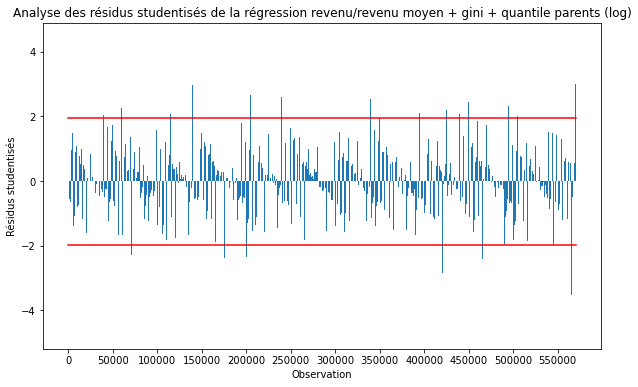

In [106]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniQuantLog['obs'], analysesRegAvincomeGiniQuantLog['rstudent'])
plt.xticks(np.arange(0, n, step=50000))
plt.title("Analyse des résidus studentisés de la régression revenu/revenu moyen + gini + quantile parents (log)")
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### 5 - Distance de Cook :

In [107]:
# Seuil de la distance de Cook :
analysesRegAvincomeGiniQuantLog['dcooks'] = regAvincomeGiniQuantLog.get_influence().cooks_distance[0]

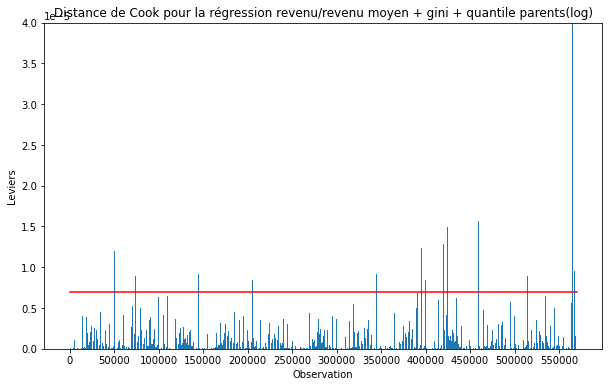

In [163]:
# Représentation :
plt.figure(figsize=(10,6))
plt.bar(analysesRegAvincomeGiniQuantLog['obs'], analysesRegAvincomeGiniQuantLog['dcooks'])
plt.xticks(np.arange(0, n, step=50000))
plt.title("Distance de Cook pour la régression revenu/revenu moyen + gini + quantile parents(log)")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.ylim(0,0.00004)
plt.show()

#### 6 - Colinéarité des variables :

In [109]:
# Calculs
variablesRegAvincomeGiniQuantLog = regAvincomeGiniQuantLog.model.exog
[variance_inflation_factor(variablesRegAvincomeGiniQuantLog, i) for i in np.arange(1,variablesRegAvincomeGiniQuantLog.shape[1])]

[1.0686762373662306, 1.0686762373662257, 1.0000000000000002]

#### 7 - homoscédasticité

In [110]:
# Calculs :
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regAvincomeGiniQuantLog.resid, variablesRegAvincomeGiniQuantLog)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.0


#### 8 - Conclusion :